In [2]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

## download dataset 
!kaggle datasets download -d vetrirah/customer

## unzip dataset
!unzip "customer.zip" -d "customer_dataset"

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=b318334fdcde360cd0359c655b144510b8612ac87a427b9cfdf88897c0fd4bdc
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


Saving kaggle.json to kaggle.json
kaggle.json
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 58.3MB/s]
Archive:  customer.zip
  inflating: customer_dataset/Test.csv  
  inflating: customer_dataset/Train.csv  
  inflating: customer_dataset/sample_submission.csv  


## Importing Libraries

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
%matplotlib inline

## EDA

In [4]:
train_data = pd.read_csv('/content/customer_dataset/Train.csv')
test_data = pd.read_csv('/content/customer_dataset/Test.csv')

In [5]:
train_data.shape, test_data.shape

((8068, 11), (2627, 10))

In [6]:
train_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [7]:
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [8]:
result = pd.DataFrame(train_data.isnull().sum())
indexes = list(result.index)

## missing values percentage 
miss_per = []
for index in indexes:
  value = str(round((result.loc[index] * 100)/train_data.shape[0], 2)[0]) + ' %'
  miss_per.append(value)

miss_per_df = pd.DataFrame(data=miss_per, index=indexes, columns=['Percentage']) 

print(miss_per_df)

                Percentage
ID                   0.0 %
Gender               0.0 %
Ever_Married        1.74 %
Age                  0.0 %
Graduated           0.97 %
Profession          1.54 %
Work_Experience    10.28 %
Spending_Score       0.0 %
Family_Size         4.15 %
Var_1               0.94 %
Segmentation         0.0 %


In [9]:
result = pd.DataFrame(test_data.isnull().sum())
indexes = list(result.index)

## missing values percentage 
miss_per = []
for index in indexes:
  value = str(round((result.loc[index] * 100)/test_data.shape[0], 2)[0]) + ' %'
  miss_per.append(value)

miss_per_df = pd.DataFrame(data=miss_per, index=indexes, columns=['Percentage']) 

print(miss_per_df)

                Percentage
ID                   0.0 %
Gender               0.0 %
Ever_Married         1.9 %
Age                  0.0 %
Graduated           0.91 %
Profession          1.45 %
Work_Experience    10.24 %
Spending_Score       0.0 %
Family_Size          4.3 %
Var_1               1.22 %


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


## Visualization

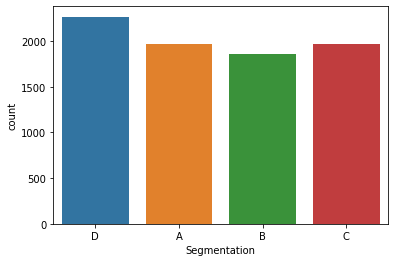

In [11]:
sns.countplot(x = 'Segmentation', data = train_data, )
plt.show()

## Data Preprocessing

In [12]:
def unique_values(miss_cat_cols):
  for col in miss_cat_cols:
    print(f"{'cat name'.title()} : {col}")
    unique_vals = train_data[col].unique()
    print(f"unique values :- {unique_vals}")
    print(f"Number :- {len(unique_vals)}")

In [13]:
miss_cat_cols = ['Ever_Married', 'Graduated', 'Profession', 'Var_1']
unique_values(miss_cat_cols)

Cat Name : Ever_Married
unique values :- ['No' 'Yes' nan]
Number :- 3
Cat Name : Graduated
unique values :- ['No' 'Yes' nan]
Number :- 3
Cat Name : Profession
unique values :- ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]
Number :- 10
Cat Name : Var_1
unique values :- ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']
Number :- 8


In [14]:
def fill_missing_val(miss_cat_cols, train_data):
  for col in miss_cat_cols:
    max_val = train_data[col].value_counts().keys()[0]
    train_data[col] = train_data[col].fillna(max_val)
  
  return train_data

train_data = fill_missing_val(miss_cat_cols, train_data)

test_data = fill_missing_val(miss_cat_cols, test_data)

In [15]:
def fill_missing_val_int(miss_int_cols, data):
  for col in miss_int_cols:
    median_val = np.nanmedian(train_data[col])
    data[col] = data[col].fillna(median_val)
  
  return data

miss_int_cols = ['Work_Experience', 'Family_Size']
train_data = fill_missing_val_int(miss_int_cols, train_data)
test_data = fill_missing_val_int(miss_int_cols, test_data)

In [16]:
## drop ID col
train_data = train_data.drop(['ID'], axis=1)
test_data = test_data.drop(['ID'], axis=1)

## Drop Var 1
train_data = train_data.drop(['Var_1'], axis=1)
test_data = test_data.drop(['Var_1'], axis=1)

In [17]:
## all columns
total_col_names = test_data.columns
## find numeric columns (int & float, bool)
num_cols = test_data._get_numeric_data().columns
## getting category columns 
cat_col_names = list(set(total_col_names) - set(num_cols))

In [18]:
cat_col_names

['Profession', 'Ever_Married', 'Graduated', 'Gender', 'Spending_Score']

In [19]:
## Apply label encoding operation on category columns
def label_encoding(col_name):
  le = LabelEncoder()
  train_data[col_name] = le.fit_transform(train_data[col_name])  
  test_data[col_name] = le.transform(test_data[col_name])

for col in cat_col_names:
  label_encoding(col)

In [30]:
train_data

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,1,0,22,0,5,1.0,2,4.0,D
1,0,1,38,1,2,1.0,0,3.0,A
2,0,1,67,1,2,1.0,2,1.0,B
3,1,1,67,1,7,0.0,1,2.0,B
4,0,1,40,1,3,1.0,1,6.0,A
...,...,...,...,...,...,...,...,...,...
8063,1,0,22,0,0,0.0,2,7.0,D
8064,1,0,35,0,4,3.0,2,4.0,D
8065,0,0,33,1,5,1.0,2,1.0,D
8066,0,0,27,1,5,1.0,2,4.0,B


In [20]:
## Separate dependent and independent variables in train dataset 
X = train_data.drop(['Segmentation'], axis=1)
y = train_data['Segmentation']

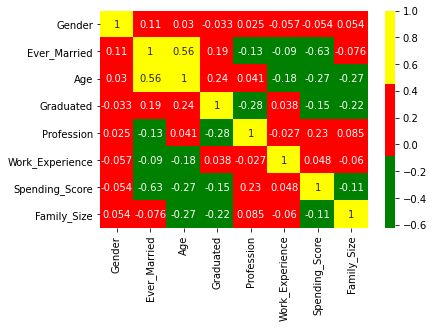

In [21]:
sns.heatmap(X.corr(), annot=True , cmap=['green', 'red', 'yellow'])
plt.show()

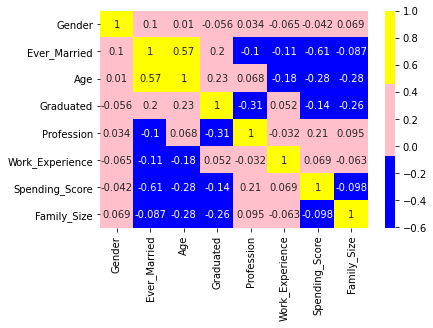

In [22]:
sns.heatmap(test_data.corr(), annot=True, cmap=['blue', 'pink', 'yellow'])
plt.show()

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [32]:
y[:10]

array([3, 0, 1, 1, 0, 2, 2, 3, 3, 2])

In [24]:
column_names = list(X.columns)

## create pipeline to apply feature scaling
pipeline = Pipeline([
                     ('std_scaler', StandardScaler())
])

## apply feature scaling on independent values (X)
X = pd.DataFrame(data=pipeline.fit_transform(X), columns=column_names)
X.head()

## label encoding on target variables
le = LabelEncoder()
y = le.fit_transform(y)

## splitting whole dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Size Of The Train Dataset :- {len(X_train)}")
print(f"Size Of The Test Dataset :- {len(X_test)}")

Size Of The Train Dataset :- 7261
Size Of The Test Dataset :- 807


## Model Building

In [29]:
## building different models
def model_building(model_name):
  model = model_name
  model.fit(X_train, y_train)
  print(f"******** Model :- {model_name} ********\n\n")
  print(f"******** Score :- {model.score(X_test, y_test)} ***********")
  print(f"******** Classification Report ************************\n\n")
  y_prediction = model.predict(X_test)
  print(classification_report(y_test, y_prediction))


## dictionary with different models
model_dict = {'dt':DecisionTreeClassifier(criterion='entropy'), 
              'knn':KNeighborsClassifier(n_neighbors=17), 
              'rf': RandomForestClassifier(), 
              'xgb':xgb.XGBClassifier(random_state=42, learning_rate=0.4)}


## calling to build and evaluate models
for key in model_dict.keys():
  model_building(model_dict[key])

******** Model :- DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') ********


******** Score :- 0.4188351920693928 ***********
******** Classification Report ************************


              precision    recall  f1-score   support

           0       0.31      0.32      0.32       198
           1       0.27      0.31      0.29       169
           2       0.44      0.41      0.42       201
           3       0.64      0.59      0.61       239

    accuracy                           0.42       807
   macro avg       0.41      0.41      0.41       807
weighted avg       0.43      0.42      0.42       807


In [48]:
model = xgb.XGBClassifier(random_state=1, learning_rate=0.4)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Evaluation

In [49]:
test_data_1 = pd.DataFrame(data=pipeline.fit_transform(test_data), columns=column_names)

In [50]:
test_data_1.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,-1.087983,0.820517,-0.450948,0.784615,-0.306934,-0.748105,0.738691,-1.207220
1,0.919132,0.820517,-0.391999,0.784615,0.853788,1.752242,-1.633608,0.768709
2,-1.087983,0.820517,1.494372,-1.274510,-1.080748,-0.748105,0.738691,-1.207220
3,0.919132,0.820517,0.904881,-1.274510,0.466881,2.689872,-0.447459,-0.548577
4,-1.087983,-1.218744,-1.453083,-1.274510,2.014510,-0.435562,0.738691,0.768709


In [51]:
y_predict = model.predict(test_data_1)

In [52]:
y_predict = y_predict.tolist()

In [53]:
for i in range(len(y_predict)):
  if y_predict[i] == 0:
    y_predict[i] = 'A'
  elif y_predict[i] == 1:
    y_predict[i] = 'B'
  elif y_predict[i] == 2:
    y_predict[i] = 'C'
  elif y_predict[i] == 3:
    y_predict[i] = 'D'

In [54]:
sample_data = pd.read_csv('/content/customer_dataset/sample_submission.csv')

In [57]:
sample_data.head()

,ID,Segmentation
0,458989,A
1,458994,B
2,458996,A
3,459000,C
4,459001,D


In [56]:
sample_data.Segmentation = y_predict

In [58]:
sample_data.to_csv('customer_segmentation_submission.csv', index=False)